# Простая линейная регрессия. Метод наименьших квадратов

Простая линейная регрессия моделирует связь между величиной одной переменной и величиной второй. Например, по мере увеличения $X$ увеличивается и $Y$ или же наоборот уменьшается. Рассмотрим на примере предсказания прибыли от продовольственных перевозок. Допустим, есть данные прибыли от перевозок еды в рестораны некоторых городов с известной численностью населения.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
headers = ['population', 'profit']
df = pd.read_csv('ex1data1.csv', names=headers)

In [3]:
df.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [4]:
x = df.population
y = df.profit

## Визуализация данных

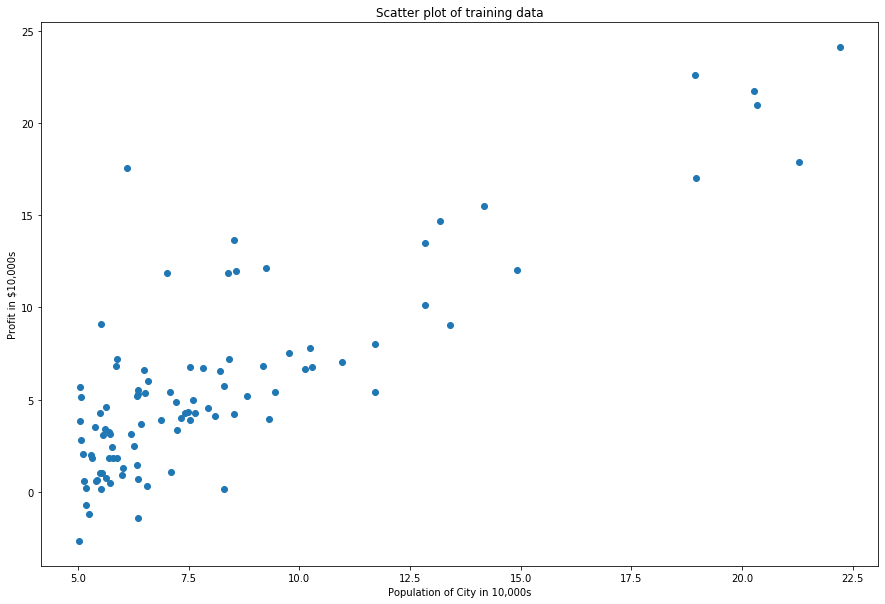

In [5]:
plt.figure(figsize=(15, 10))
plt.scatter(df.population, df.profit)
plt.ylabel('Profit in $10,000s')
plt.xlabel('Population of City in 10,000s')
plt.title('Scatter plot of training data')
plt.show()

## Корреляция

Из графика видно, что с увеличением численности населения увеличивается и прибыль. Корреляция — ещё один способ измерить, каким образом связаны две переменные.

In [6]:
df.corr()

,population,profit
population,1.000000,0.837873
profit,0.837873,1.000000


Выше представлена таблица корреляций (или корреляционная матрица). Она состоит из выборочных коэффициентов корреляции, каждый из которых измеряет степень, с какой числовые переменные связаны друг с другом в диапозоне от -1 (идеальная отрицательная корреляция) до 1 (идеальная положительная корреляция). Значение 0 свидетельствует об отсутствии корреляции. Каждый выборочный коэффициент корреляции из корреляционной матрицы вычисляется по формуле
$$ \hat r_{xy} = \dfrac{\sum\limits_{i = 1}^{n} \left( x_i - \overline{x} \right) \left( y_i - \overline{y} \right)}{n \hat s_x \hat s_y}, $$
где $\hat s_x = \sqrt{\hat d_x(n)}$, $\hat s_y = \sqrt{\hat d_y(n)}$ — стандартные отклонения, где
$$ \hat d_x(n) = \dfrac{\sum\limits_{i = 1}^{n} \left( x_i - \overline{x} \right)^2}{n}, \quad \hat d_y(n) = \dfrac{\sum\limits_{i = 1}^{n} \left( y_i - \overline{y} \right)^2}{n}, $$
называются выборочными дисперсиями, а $\overline{x}$, $\overline{y}$ — выборочные средние:
$$ \overline{x} = \hat m_x(n) = \dfrac{1}{n} \sum\limits_{i = 1}^{n} x_i, \quad \overline{y} = \hat m_y(n) = \dfrac{1}{n} \sum\limits_{i = 1}^{n} y_i. $$

In [7]:
def sample_mean(x):
    n = len(x)
    return np.sum(x) / n


def sample_std(x):
    n = len(x)
    return np.sqrt(np.sum((x - sample_mean(x)) ** 2) / n)


def sample_r(x, y):
    n = len(x)
    return np.sum((x - sample_mean(x)) * (y - sample_mean(y)) / (n * sample_std(x) * sample_std(y)))

In [8]:
print('Correlation coefficient =', sample_r(x, y))

Correlation coefficient = 0.837873232526341


Таким образом мы получили значение коэффициента корреляции для прибыли продовольственных перевозок и численности населения, который в корреляционной матрице находится на побочной диагонали. Поскольку его значение ближе к единице, можно говорить о положительной корреляции этих переменных.

В отличие от корреляции, линейная регрессия позволяет квантифицировать природу этой взаимосвязи и предсказать приблизительное значение прибыли для городов с численностью населения, отличной от известных нам.

## Модель линейной регрессии

Простая линейная регрессия оценивает, насколько именно изменится $y$, когда $x$ изменится на определенную величину. Для коэффициента корреляции переменные взаимозаменяемы, о чем говорит симметричность корреляционной матрицы. В случае же с регрессией мы пытаемся предсказать переменную $y$ из переменной $x$, используя линейное соотношение
$$ y = \theta_0 + \theta_1 x, $$
где $\theta_0$ называется _пересечением_, а $\theta_1$ — _наклоном_ для $x$. Переменная $y$ называется _откликом_, _целью_ или _зависимой_ переменной, а $x$ называется _предиктором_, _вектором признаков_ или _независимой_ переменной.

Поскольку уравнение регрессии задано линейным соотношением, то и в результате мы получим прямую. Как правило она не проходит точно через все имеющиеся данные, поэтому уравнение регрессии должно включать в себя заданный в явной форме остаточный член $e$, который является случайной величиной:
$$ y = \theta_0 + \theta_1 x + e.$$
_Подогнанные_, или _предсказанные_, значения задаются следующей формулой:
$$ \hat{y} = \theta_0 + \theta_1 x.$$
Форма записи коэффициентов регрессии (с шляпой) говорит о том, что они оценочные (расчетные) в отличие от точных.

In [9]:
def predict(theta_0, theta_1, x):
    return theta_0 + theta_1 * x

## Метод максимального правдоподобия

Пусть имеется выборка данных $v_1, \dots, v_n$, которая порождается распределением, зависящим от некоторого неизвестного параметра $\varphi$:
$$ p(v_1, \dots, v_n | \varphi). $$
Если параметр $\varphi$ неизвестен, то можно поменять члены местами, чтобы представить эту величину, как _правдоподобие_ параметра $\varphi$ при наличии выборки:
$$ L(\varphi | v_1, \dots, v_n). $$
Согласно такому подходу наиболее правдоподобным значением $\varphi$ является то, которое максимизирует эту функцию правдоподобия, т. е. значение, которое делает наблюдаемые данные наиболее вероятными.

Одно из допущений, которое нередко принимается относительно модели простой линейной регрессии, заключается в том, что случайные ошибки регрессии нормально распределены с нулевым средним и неким (известным) стандартным отклонением $\sigma$. В этом случае правдоподобие на основе наблюдаемой пары $(x_i, y_i)$ равно:
$$ L\left(\theta_0, \theta_1 | x_i, y_i, \sigma \right) = \dfrac{1}{\sqrt{2 \pi \sigma}} \exp{\dfrac{-\left( y_i - \theta_0 - \theta_1 x_i \right)^2}{2 \sigma^2}}. $$
Правдоподобие на основе всего набора данных является произведением индивидуальных правдоподобий:
$$ L\left( \theta_0, \theta_1 | x, y, \sigma \right) = \prod\limits_{i = 1}^{n} L\left( \theta_0, \theta_1 | x_i, y_i, \sigma \right) = \dfrac{1}{\left(2\pi\sigma\right)^{n / 2}}  \exp{\dfrac{- \sum\limits_{i = 1}^n \left( y_i - \theta_0 - \theta_1 x_i \right)^2}{2 \sigma^2}}. $$
Такая функция правдоподобия максимальна тогда, когда минимальна _сумма квадратов случайных ошибок_, или _остаточная сумма квадратов (RSS)_. Таким образом, мы приходим к методу наименьших квадратов.

## Метод наименьших квадратов

Итак, прямая регрессии является оценкой, которая минимизирует остаточную сумму квадратов:
$$ RSS(\theta_0, \theta_1) = \sum\limits_{i = 1}^{n} \left( y_i - \hat{y_i} \right)^2 = \sum\limits_{i = 1}^{n} \left( y_i - \theta_0 - \theta_1 x_i \right)^2, $$
где $\theta_0$ и $\theta_1$ — это значения, которые минимизируют $RSS$.

In [10]:
def sum_of_squared_errors(theta_0, theta_1, x, y):
    return np.sum((y - predict(theta_0, theta_1, x)) ** 2)

Для удобства сумму в $RSS$ часто домножают константой $\dfrac{1}{2n}$:
$$ RSS(\theta_0, \theta_1) = \dfrac{1}{2n} \sum\limits_{i = 1}^{n} \left( y_i - \theta_0 - \theta_1 x_i \right)^2. $$

Методом минимизации суммы квадратических остатков называется _методом наименьших квадратов_. Он основан на необходимом условии существования экстремума функции многих переменных, которое требует равенства нулю первых частных производных по переменным, по которым минимизируется функция.

То есть, должны выполняться равенства
$$ \dfrac{\partial RSS}{\partial \theta_0} = \dfrac{1}{n} \sum\limits_{i = 1}^{n} \left( y_i - \theta_0 - x_i \theta_1 \right) \cdot (-1) = -\dfrac{1}{n} \sum\limits_{i} y_i + \theta_0 + \dfrac{\theta_1}{n} \sum\limits_{i} x_i = 0, $$
$$ \dfrac{\partial RSS}{\partial \theta_1} = \dfrac{1}{n} \sum\limits_{i = 1}^{n} \left( y_i - \theta_0 - x_i \theta_1 \right) \cdot \left( -x_i \right) = -\dfrac{1}{n} \sum\limits_i y_i x_i + \dfrac{\theta_0}{n} \sum\limits_i x_i + \dfrac{\theta_1}{n} \sum\limits_i x_i^2 = 0. $$
Откуда
$$ \theta_0 = \dfrac{1}{n} \sum\limits_i y_i - \dfrac{\theta_0}{n} \sum\limits_i x_i = \overline{y} - \theta_1 \overline{x}, $$
$$ \theta_1 = \dfrac{\sum\limits_i y_i x_i - \dfrac{1}{n}\sum\limits_i y_i \sum\limits_i x_i}{\sum\limits_i x_i^2 - \dfrac{1}{n} \left( \sum\limits_i x_i \right)^2}. $$

Можно заметить, что
$$ \theta_1 = \dfrac{Cov(x, y)}{\hat{d}_x(n)} = \hat r_{xy} \sqrt{\dfrac{\hat d_y(n)}{\hat d_x(n)}} = \hat r_{xy} \dfrac{\hat s_y}{\hat s_x}, $$
$$ \theta_0 = \hat m_y(n) - \theta_1 \hat m_x(n), $$
где $Cov(x, y)$ — выборочная ковариация.

По полученным уравнениям можем найти значения коэффициентов регрессии для нашего примера.

In [11]:
def least_squares_fit(x, y):
    theta_1 = sample_r(x, y) * sample_std(y) / sample_std(x)
    theta_0 = sample_mean(y) - theta_1 * sample_mean(x)
    return theta_0, theta_1

theta_0, theta_1 = least_squares_fit(x, y)
print('Coeffitients of regression:', theta_0, theta_1)

Coeffitients of regression: -3.8957808783118555 1.1930336441895941


Посмотрим, какая ожидается прибыль от городов с населением 35000 и 70000 человек.

In [12]:
profit_35k = round(predict(theta_0, theta_1, 3.5) * 10000)
profit_70k = round(predict(theta_0, theta_1, 7) * 10000)

print(f'For population of 35,000 people we predict a profit of {profit_35k}$.\nFor population of 70,000 people we predict a profit of {profit_70k}$.')

For population of 35,000 people we predict a profit of 2798.0$.
For population of 70,000 people we predict a profit of 44555.0$.


На графике изображена полученная прямая линейной регрессии.

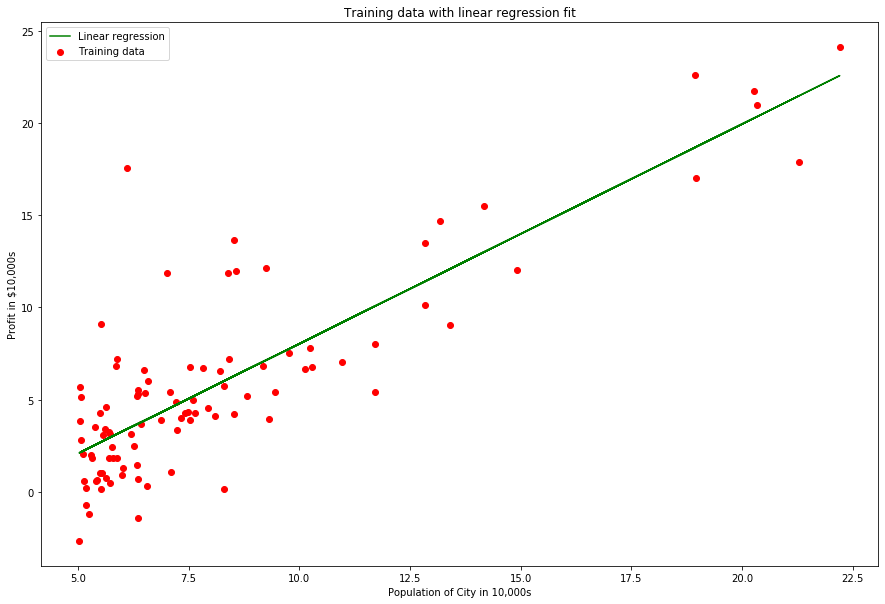

In [13]:
plt.figure(figsize=(15, 10))
plt.scatter(x, y, color='red')
plt.plot(x, predict(theta_0, theta_1, x), color='green')
plt.ylabel('Profit in $10,000s')
plt.xlabel('Population of City in 10,000s')
plt.legend(['Linear regression', 'Training data'])
plt.title('Training data with linear regression fit')
plt.show()

## Оценка модели

Оценить качество модели можно, просто подсчитав остаточную сумму квадратов, которая фигурировала в методе наименьших квадратов. Часто эту сумму делят на размер выборки $n$, тогда ошибка называется среднеквадратической ошибкой.

In [14]:
def mean_squared_error(theta_0, theta_1, x, y):
    n = len(x)
    return sum_of_squared_errors(theta_0, theta_1, x, y) / n


mse = mean_squared_error(theta_0, theta_1, x, y)
print('Mean squared error =', mse)

Mean squared error = 8.953942751950358


Чем меньше значение среднеквадратическая ошибка, тем лучше работает модель. Недостатком этого способа является то, что непонятно, от какого значения отталкиваться. Является ли полученное выше значение хорошей оценкой или плохой? Другой распространенной мерой оценки качества подгонки является _коэффициент детерминации_ ($R_2$, _R-квадрат_), который измеряет долю суммарной вариации в зависимой переменной, объясняемой моделью. Для этого из единицы надо вычесть долю вариации, не объясненной моделью.

In [15]:
def total_sum_of_squares(y):
    return np.sum((y - sample_mean(y)) ** 2)


def r_squared(theta_0, theta_1, x, y):
    return 1.0 - (sum_of_squared_errors(theta_0, theta_1, x, y) / total_sum_of_squares(y))

Очевидно, что значение коэффициента детерминации находится в промежутке между 0 и 1 ($R_2 \in [0, 1]$). Чем ближе его значение к единице, тем лучше подгонка модели к данным.

In [16]:
r2 = r_squared(theta_0, theta_1, x, y)
print('R-squared error =', r2)

R-squared error = 0.7020315537841397


Полученное значение коэффициента детерминации говорит, что в целом модель достаточно хорошо описывает наши данные.

# Список использованных источников

1. Материалы курса Machine Learning - Andrew Ng, Stanford University on Coursera.
2. Грас Дж. Data Science. Наука о данных с нуля: Пер. с англ. — СПб.: БХВ-Петербург, 2019. — 336 с.: ил.
3. Брюс, П. Практическая статистика для специалистов Data Science: Пер. с англ. / П. Брюс, Э Брюс. — СПб.: БХВ-Петербург, 2019. — 304 с.: ил.
4. Кибзун А. И., Горяинова Е. Р., Наумов А. В. Теория вероятностей и математическая статистика. Базовый курс с примерами и задачами: Учебник. — 3-е изд., перераб. и доп. — М.: ФИЗМАТЛИТ, 2013. — 232 с.
5. http://www.machinelearning.ru/wiki/images/f/fc/MOTP14_3.pdf